In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import concurrent.futures
import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skipper_image_analysis.utils import (
    correct_overscan, get_rowcol_ovserscan, prepare_frame, filtro_dipolos
)

# def intensidad_func(tph, tau, Pc):
#     npump = 40000
#     return npump*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))


# def tau_func(T, e_kb, tau_0):
#     return tau_0/(T**2)*np.exp(e_kb/T)


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    135: ["skipper_data/TRAPS/25MAR2024_135K/"],
    140: ["skipper_data/TRAPS/26MAR2024_140K/"],
    145: ["skipper_data/TRAPS/22MAR2024_145K/"],
    153: ["skipper_data/TRAPS/25MAR2024_153K/"],
    172: [
        "skipper_data/TRAPS/03ABR2024_172K/",
        "skipper_data/TRAPS/05ABR2024_172K/",
    ],
}
DATA_DIR_COUNT = sum([len(dir_list) for dir_list in CARPETAS_POR_TEMP.values()])
RESULTS_DIR = "skipper_image_analysis/TRAPS_estudio_fondo"
CLOCKS_TO_SEC = 15e6  # Hz
DTPH_VALS = np.array(
    [50, 75, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200, 76800]
)
# Define Bins so that each value is at the center of the bin in a log scale
DTPH_BINS = np.sqrt(DTPH_VALS[1:] * DTPH_VALS[:-1])
DTPH_BINS = np.insert(DTPH_BINS, 0, DTPH_VALS[0]*0.8)
DTPH_BINS = np.append(DTPH_BINS, DTPH_VALS[-1]*1.2)

bounds = np.arange(135-2.5, 170+2.5, 5)
norm = mcolors.BoundaryNorm(bounds, plt.cm.plasma.N, extend="max")
temp_colors = plt.cm.ScalarMappable(
    norm=norm,
    cmap="plasma",
)
dtph_colors = plt.cm.ScalarMappable(
    norm=mcolors.LogNorm(DTPH_VALS[0]/CLOCKS_TO_SEC, DTPH_VALS[-1]/CLOCKS_TO_SEC),
    cmap="viridis"
)

In [5]:
x = "proc_skp_pocket_oled1row_2film_dTph50_NPUPMPS3000_NSAMP1_NROW879_NCOL336_EXPOSURE8.0_img180.fits"
int(x.rsplit("_")[5][4:])

50

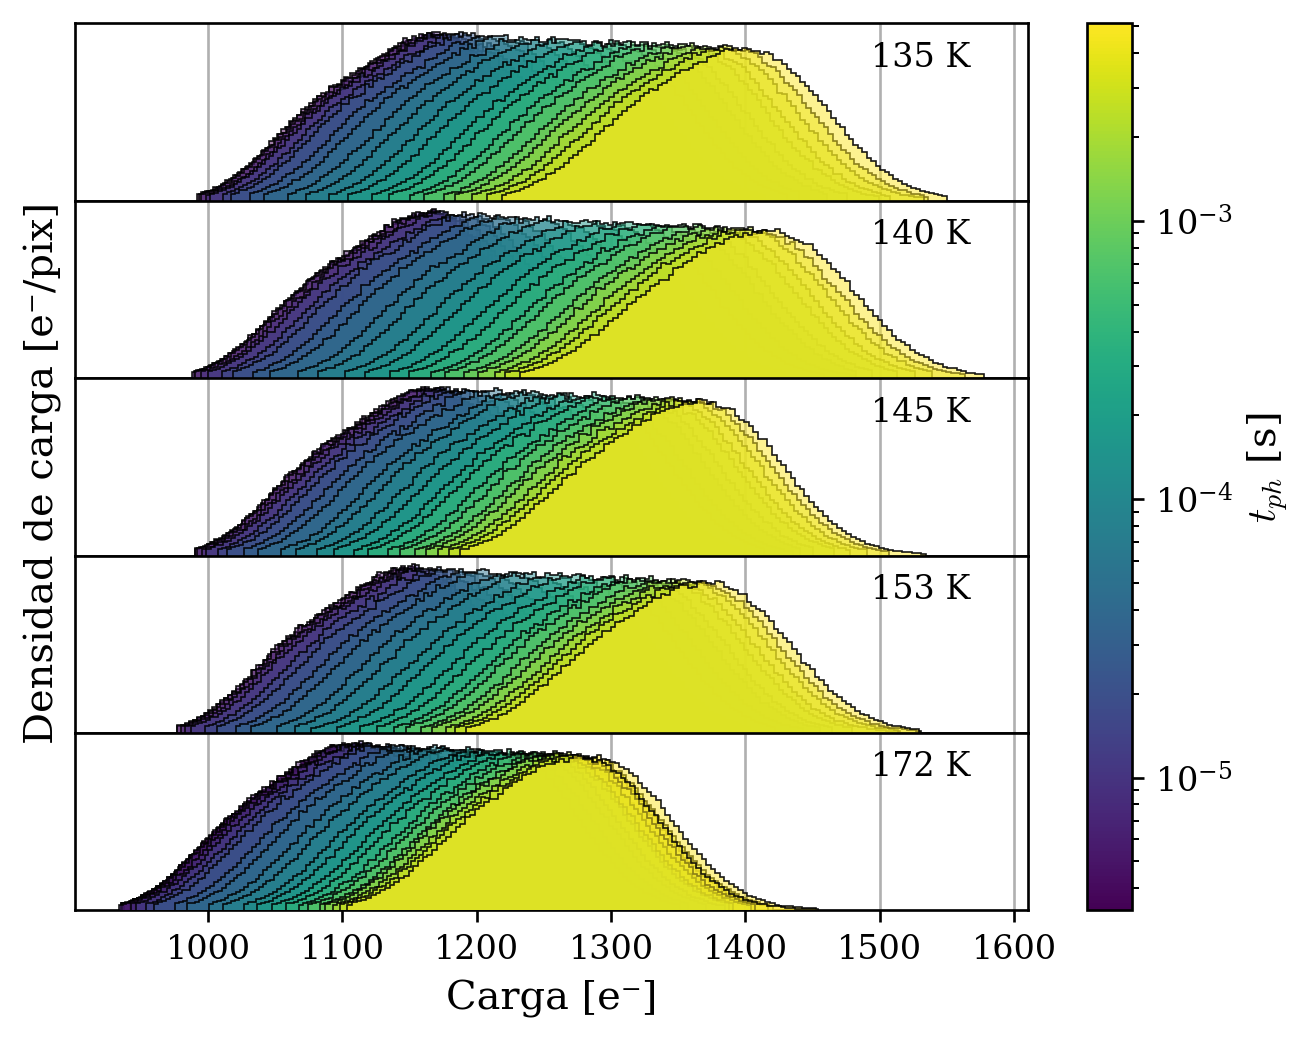

In [8]:
# Graficamos la distribución de carga para cada barrido
plt.close("all")
%matplotlib inline    
dists_por_dir = {}

fig, axs = plt.subplots(len(CARPETAS_POR_TEMP), 1, sharex=True)
fig.subplots_adjust(hspace=0)
ax_idx = 0
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        files_in_dir = [
            file for file in os.listdir(data_dir)
            if (file.endswith(".fits") and ("dTph" in file))
        ]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        tph_vals = []
        medianas = []
        standard_devs =  []
        ax = axs[ax_idx]
        for file in files_in_dir:
            test_image = fits.open(f'{data_dir}/{file}')
            # print(data_dir, file, sep="")
            dtph = int(file.rsplit("_")[5][4:])
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            carga_area_activa = []
            for frame_idx in [0, 1]:
                # area_activa, _, _ = prepare_frame(test_image, frame_idx)
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                area_activa = test_frame[1:-row_overscan_len, PRESCAN_PIX:-col_overscan_len]
                # area_activa = test_frame[-row_overscan_len:, PRESCAN_PIX:-col_overscan_len]
                # area_activa = test_frame.copy()
                carga_area_activa.append(area_activa.flatten())
            carga_area_activa = np.concatenate(carga_area_activa)
            medianas.append(np.median(carga_area_activa))
            carga_area_activa = carga_area_activa[
                (carga_area_activa > np.quantile(carga_area_activa, 0.005))
                & (carga_area_activa < np.quantile(carga_area_activa, 0.99))
            ]
            standard_devs.append(
                np.std(
                    carga_area_activa,
                    ddof=1
                )
            )
            tph_vals.append(dtph/CLOCKS_TO_SEC)
            ax.hist(
                carga_area_activa,
                bins=100,
                color=dtph_colors.to_rgba(dtph/CLOCKS_TO_SEC),
                alpha=0.5, density=True, zorder=10
            )
            ax.hist(
                carga_area_activa,
                bins=100,
                color="k", histtype="step", lw=0.5,
                alpha=0.9, density=True, zorder=10
            )
        dists_por_dir[data_dir] = (medianas, standard_devs, tph_vals)
    # ax.set_xticks([])
    # ax.set_xlim(1000, 4500)
    ax.text(0.94, 0.9, f"{temperatura} K",
            # c=temp_colors.to_rgba(temperatura),
            transform=ax.transAxes, ha="right", va="top")
    ax.grid(True)
    ax.set_yticks([])
    # ax.set_ylabel(f"{temperatura} K")
    if ax_idx == 1:
        ax.set_ylabel("Densidad de carga [e⁻/pix]", loc="top")
    ax_idx += 1
# ax.set_xticks(range(1000, 5000, 500))
# ax.set_xlim(1000, 4500)
ax.set_xlabel("Carga [e⁻]")
fig.colorbar(dtph_colors, label="$t_{ph}$ [s]", ax=axs)
plt.show()